# Image classifier for flowers

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, an image classifier to recognize different species of flowers will be trained. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, a few examples are shown below. 

![Flowers](https://raw.githubusercontent.com/Zi-Ao-Huang/Udacity_Image_classifier_for_flowers/master/assets/Flowers.png)
The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content



*References of this work including various Udacity tutorials and code examples available online:* 
[Ref.1](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)
[Ref.2](https://pymotw.com/3/argparse/)
[Ref.3](https://github.com/fotisk07/Image-Classifier/blob/master/Image%20Classifier%20Project.ipynb)

In [0]:
# Imports libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise we can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. we'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

Load images from the flowers folder, including dataset for training, validation and testing.


In [0]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

Define transforms for the training sets and apply transformations such as random scaling, cropping, and flipping to help the network generalize leading to better performance. 

In [0]:
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

Define transforms for the validation and testing sets, resize and crop the images to the appropriate size.


In [0]:
validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])
testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

Load the datasets with ImageFolder

In [0]:
train_data = datasets.ImageFolder(data_dir + '/train', transform=training_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=testing_transforms)

Using the image datasets and the trainforms, define the dataloaders

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will provide a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(cat_to_name)
print("\n Length:", len(cat_to_name))

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

Load a pre-trained VGG network, and use GPU if it's available

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 104259068.78it/s]


Freeze parameters so we don't backprop through them

In [0]:
for param in model.parameters():
    param.requires_grad = False

Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

In [0]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 512)),
                          ('dropout', nn.Dropout(p=0.2)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 102)), # 102 flower categories
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Train the classifier layers using backpropagation using the pre-trained network to get the features

In [0]:
epochs = 3
steps = 0
running_loss = 0
print_every = 20

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        #Track the loss and accuracy on the validation set
        #to determine the best hyperparameters
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    group_loss = criterion(logps, labels)
                    test_loss += group_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(validloader):.3f}.. "
                  f"Accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 4.560.. Validation loss: 3.550.. Accuracy: 0.259
Epoch 1/3.. Train loss: 3.542.. Validation loss: 2.709.. Accuracy: 0.362
Epoch 1/3.. Train loss: 3.024.. Validation loss: 2.036.. Accuracy: 0.513
Epoch 1/3.. Train loss: 2.589.. Validation loss: 1.625.. Accuracy: 0.597
Epoch 1/3.. Train loss: 2.309.. Validation loss: 1.393.. Accuracy: 0.638
Epoch 1/3.. Train loss: 1.989.. Validation loss: 1.338.. Accuracy: 0.632
Epoch 1/3.. Train loss: 1.976.. Validation loss: 1.145.. Accuracy: 0.690
Epoch 1/3.. Train loss: 1.793.. Validation loss: 1.068.. Accuracy: 0.696
Epoch 1/3.. Train loss: 1.694.. Validation loss: 1.121.. Accuracy: 0.675
Epoch 1/3.. Train loss: 1.561.. Validation loss: 0.955.. Accuracy: 0.728
Epoch 2/3.. Train loss: 1.464.. Validation loss: 0.983.. Accuracy: 0.730
Epoch 2/3.. Train loss: 1.536.. Validation loss: 0.865.. Accuracy: 0.762
Epoch 2/3.. Train loss: 1.373.. Validation loss: 0.881.. Accuracy: 0.748
Epoch 2/3.. Train loss: 1.340.. Validation loss: 0.

## Testing the network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way we did validation. We should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [0]:
#Do validation on the test set
correct = 0
total = 0
model.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))

Accuracy on the test images: 73 %


## Save the checkpoint

Now that our network is trained, save the model so we can load it later for making predictions. 

In [0]:
# Save the checkpoint 
model.class_to_idx = train_data.class_to_idx

checkpoint = {'input_size': 25088,
              'hidden_layer': 512,
              'output_size': 102,
              'arch': 'vgg19',
              'classifier': classifier,
              'learning_rate': 0.001,
              'epochs': epochs,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
             }

torch.save(checkpoint,'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [0]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    checkpoint = torch.load(path)
    
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    learning_rate = checkpoint['learning_rate']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.optimizer = checkpoint['optimizer']
    model.class_to_idx = checkpoint['class_to_idx']
  
    return model

model = load_checkpoint('checkpoint.pth')  
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. we can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''    
    image = Image.open(image)
    image = image.resize((256,256))
    
    left = (256-224)/2
    top = (256-224)/2
    right = (256+224)/2
    bottom = (256+224)/2
    image = image.crop((left, top, right, bottom))
    
    image = np.array(image)/255
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    
    image = (image - mean) / std
    image = image.transpose((2,0,1))
    
    return image

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

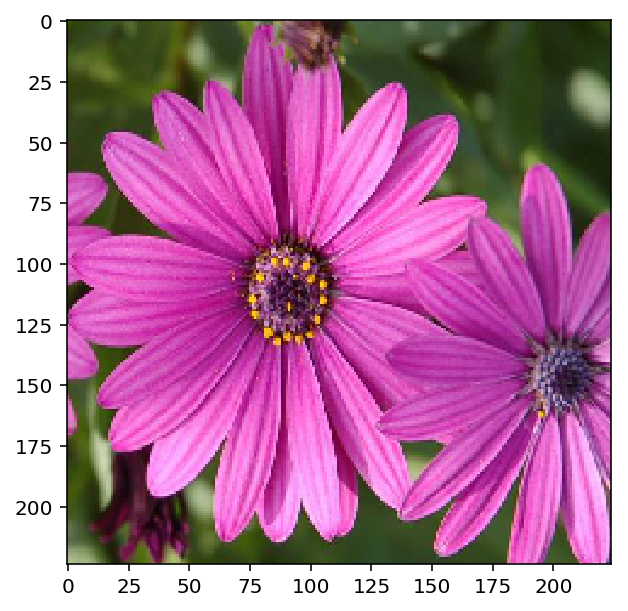

In [0]:
image = ("flowers/test/66/image_05549.jpg")
img = process_image(image)
imshow(img)

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which hopefully we added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = torch.from_numpy(img_torch)

    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probs = F.softmax(output.data,dim=1)    

    top_prob = np.array(probs.topk(topk)[0][0])
    
    class_to_idx = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [class_to_idx[x] for x in np.array(probs.topk(topk)[1][0])]
    
    return top_prob, top_classes

[ 0.94367933  0.02004582  0.01645351  0.01115336  0.00448386]
['66', '34', '100', '32', '86']


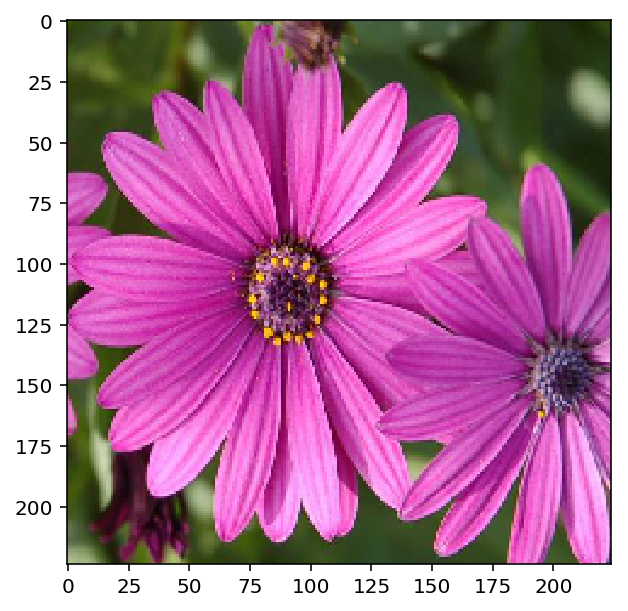

In [0]:
image = ("flowers/test/66/image_05549.jpg")
img = process_image(image)
imshow(img)
probs, classes = predict(image, model)
print(probs)
print(classes)

## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:
![inference_example](https://raw.githubusercontent.com/Zi-Ao-Huang/Udacity_Image_classifier_for_flowers/master/assets/inference_example.png)
<img src='assets/inference_example.png' width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

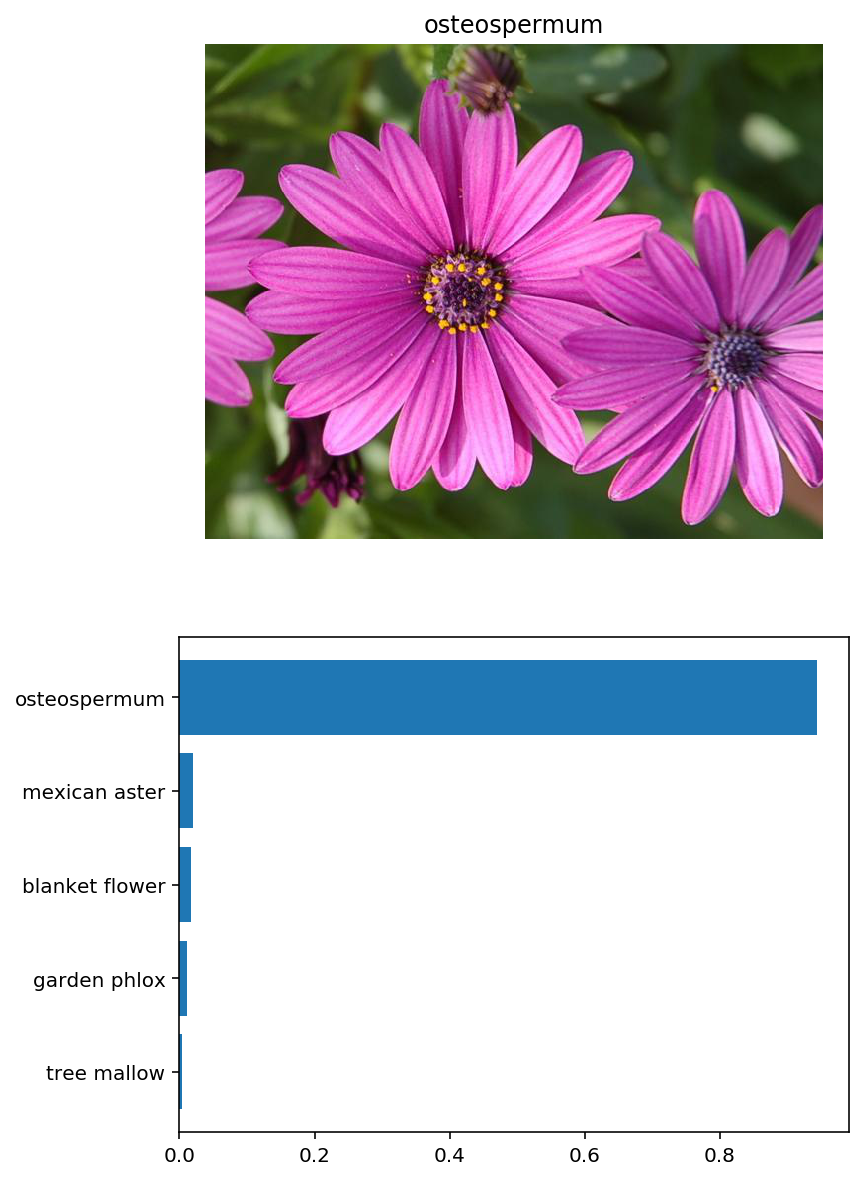

In [0]:
# image = ("flowers/test/66/image_05549.jpg")
img = Image.open(image)
max_index = classes[0]
flower_name = cat_to_name[str(max_index)]

fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)

ax1.set_title(flower_name)
ax1.axis('off')
ax1.imshow(img)

names = [cat_to_name[str(index)] for index in classes]
y_pos = np.arange(len(names))
y_prob = np.array(probs)

ax2.barh(y_pos, y_prob, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(names)
ax2.invert_yaxis()